<a href="https://colab.research.google.com/github/apondi-911/testimonial/blob/main/CNNEndoModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Setup and Load Data**

####Connecting Google colab with GoogleDrive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Installing the necessary libraries

In [ ]:
import os
import numpy as np
import cv2
import seaborn as sns
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten,BatchNormalization,Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy



####Checking list of Directories in the Dataset

In [ ]:
data_dir='/content/drive/MyDrive/Data'
os.listdir(data_dir)

['Other_Images', 'no_pathology', 'pathology']

####Testing Whether the directories contain the Images

In [ ]:
img=cv2.imread(os.path.join('/content/drive/MyDrive/Data/no_pathology/f_1.jpg'))
img.shape

(360, 640, 3)

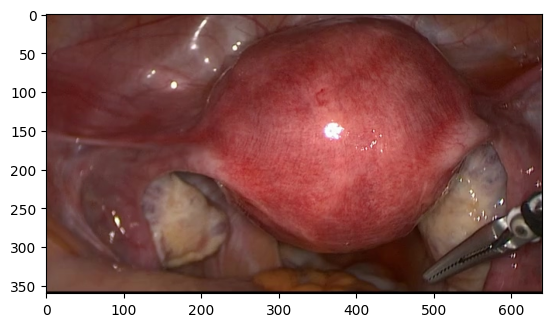

In [ ]:
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()

# 1.**Load Data**


##Number of files in each directory

In [ ]:
import os

Other_Images = "/content/drive/MyDrive/Data/Other_Images"
no_pathology = "/content/drive/MyDrive/Data/no_pathology"
pathology = "/content/drive/MyDrive/Data/pathology"

num_files_dir1 = len(os.listdir(Other_Images))
num_files_dir2 = len(os.listdir(no_pathology))
num_files_dir3 = len(os.listdir(pathology))

print("Number of files in directory 1:", num_files_dir1)
print("Number of files in directory 2:", num_files_dir2)
print("Number of files in directory 3:", num_files_dir3)

total_num_files = num_files_dir1 + num_files_dir2 + num_files_dir3
print("Total number of files in dataset:", total_num_files)

Number of files in directory 1: 706
Number of files in directory 2: 3366
Number of files in directory 3: 841
Total number of files in dataset: 4913


In [ ]:
data = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=123,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 4913 files belonging to 3 classes.


In [ ]:
tf.random.set_seed(0)

In [ ]:
class_names=data.class_names 
class_names

['Other_Images', 'no_pathology', 'pathology']

###Displaying Number of Images in each class


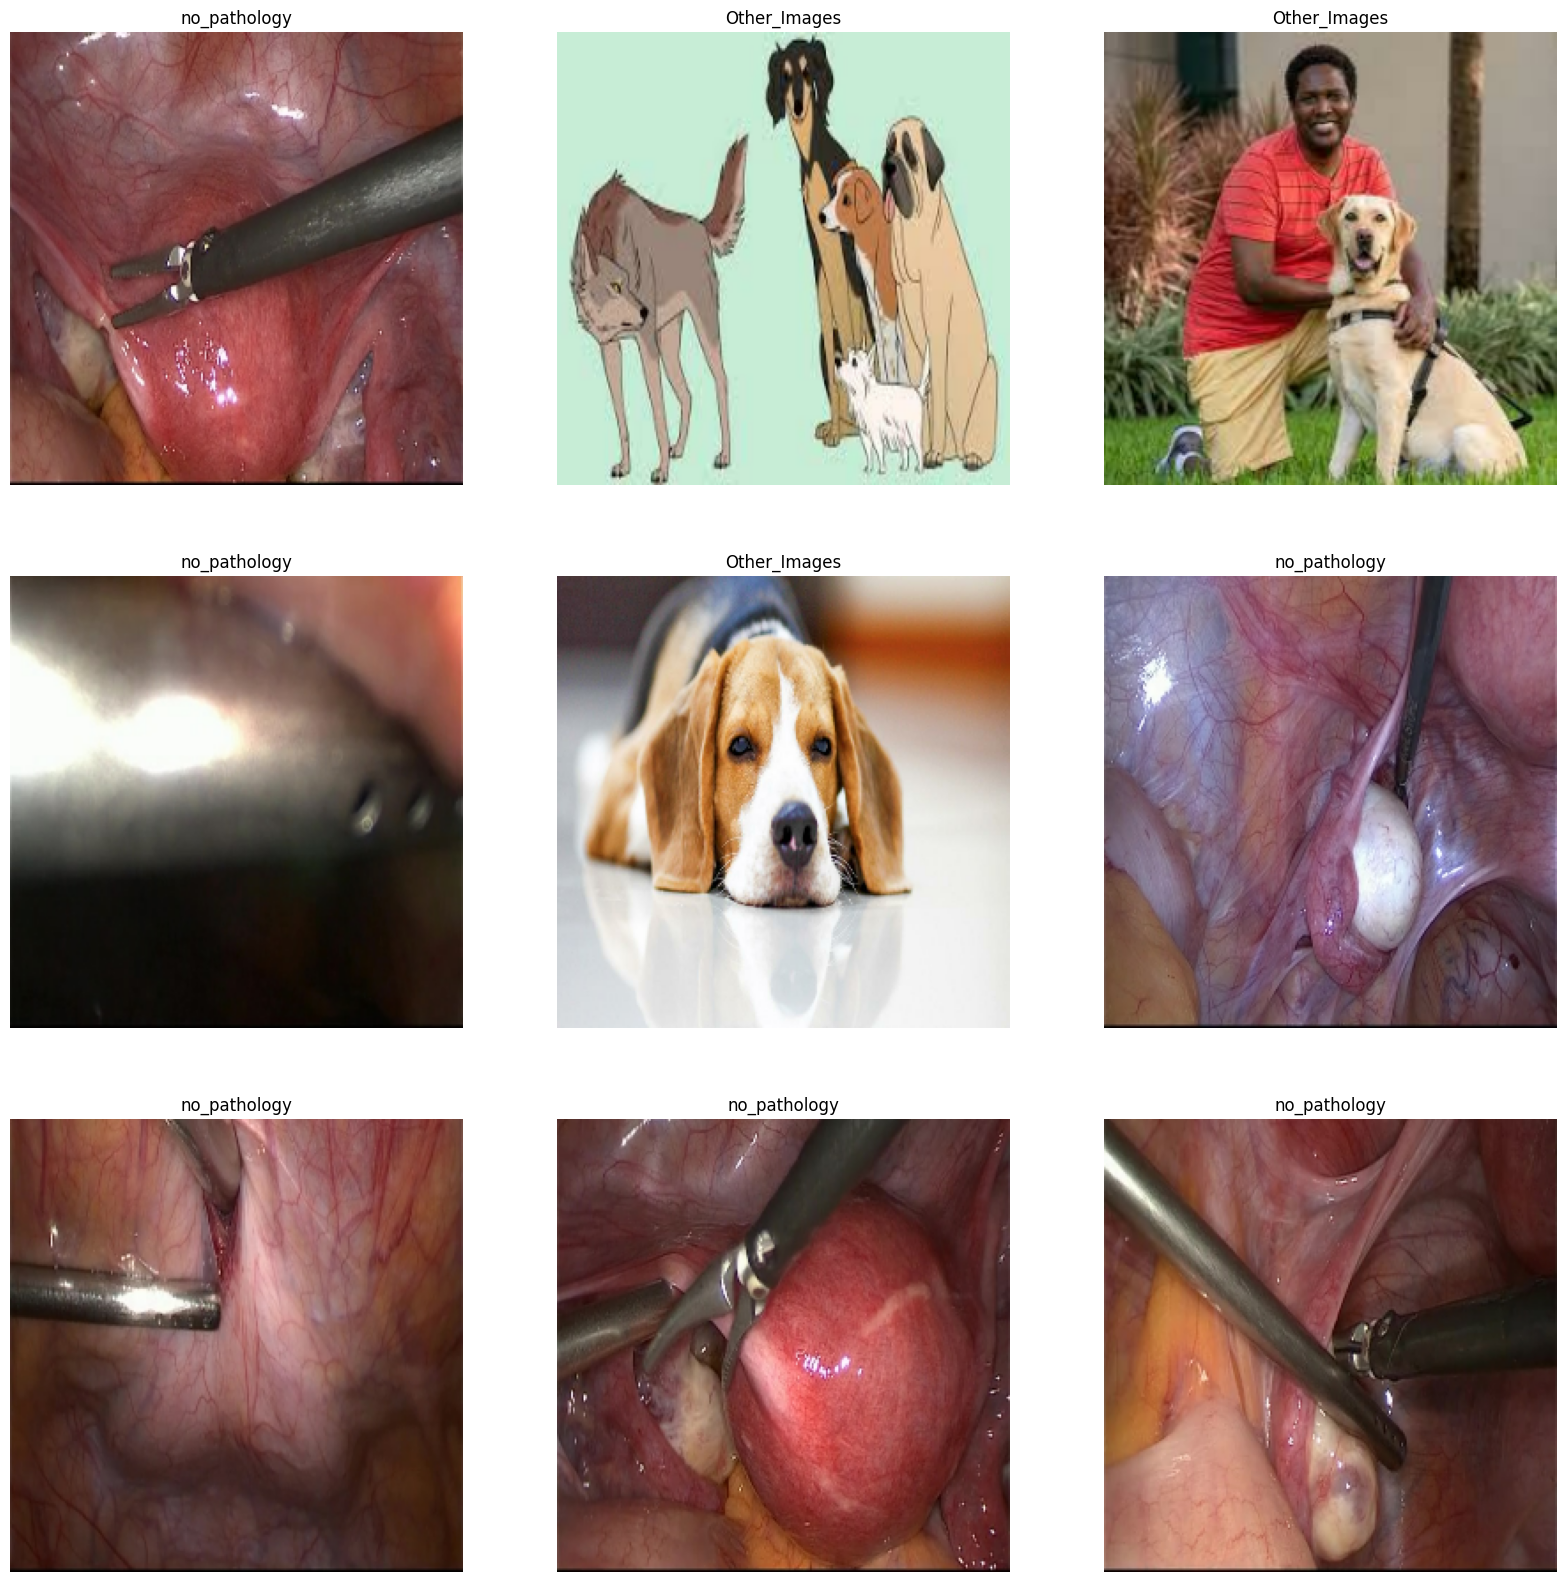

In [ ]:
plt.figure(figsize=(20, 20))
for images, labels in data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[int(np.argmax(labels[i]))])
    plt.axis("off")
plt.show()

# **2. Data Pre-processing and augmentation**



### 2.1 Augmenting the data

This involves rotation and flipping our images from the dataset so as to increase the number to obtain better results.

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.1),
  layers.RandomZoom(0.1),
  layers.RandomContrast(0.1)
])

In [ ]:
aug_ds = data.map(lambda x, y: (data_augmentation(x), y), 
                num_parallel_calls=tf.data.AUTOTUNE)

### 2.2 Displaying the augmented the data

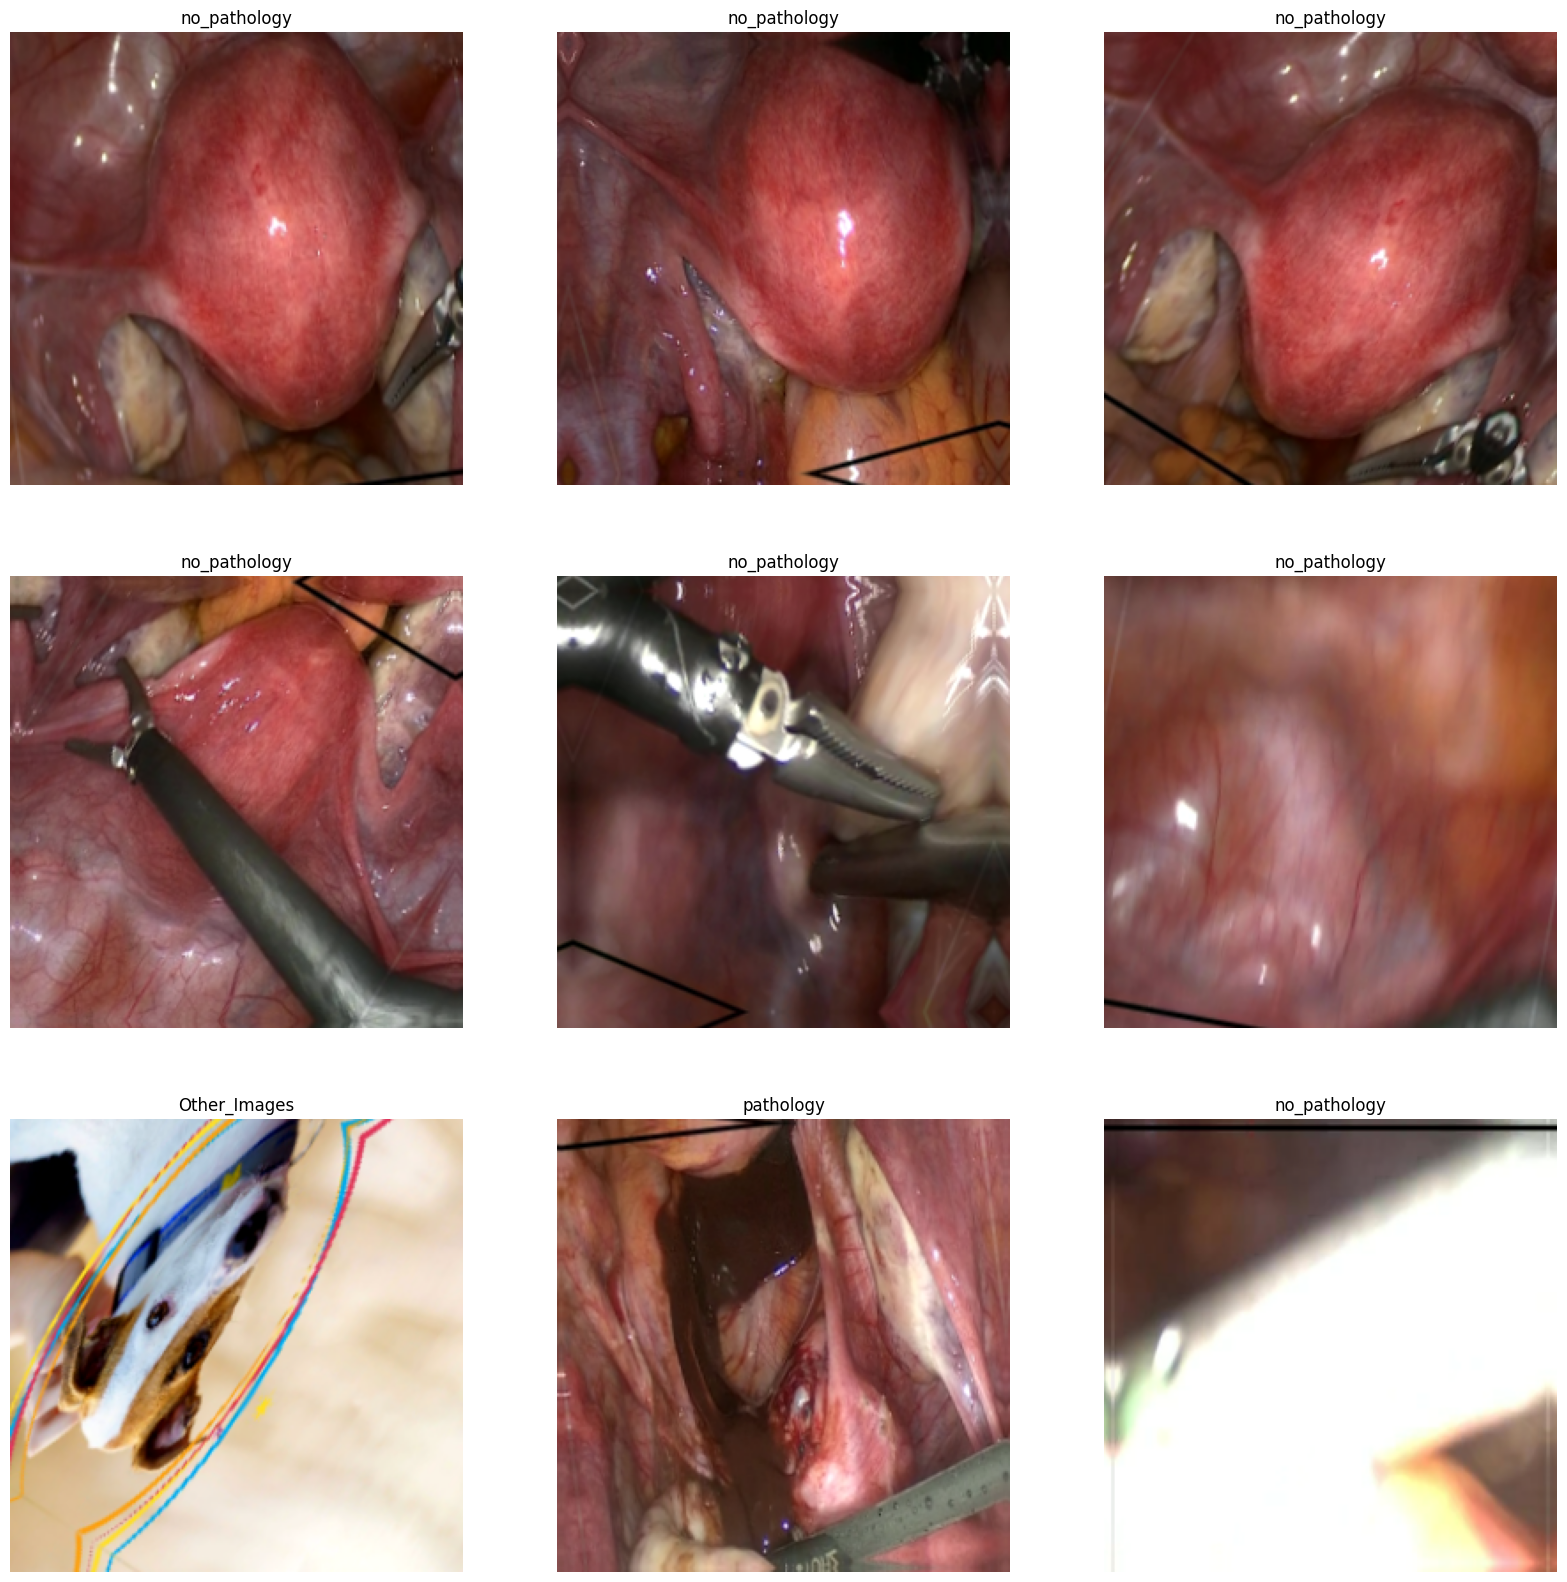

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))
for images, labels in aug_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[int(np.argmax(labels[i]))])
    plt.axis("off")
plt.show()

### 2.3 Feature Scaling data

####Scaling the Augmented Images

#####The main goal of scaling is to ensure that each feature of the data has a similar scale or range of values, typically between 0 and 1.It can improve the performance of the model, reduce overfitting, and help avoid convergence issues during training.

In [ ]:
aug_ds= aug_ds.map(lambda x, y:(x/255,y))

In [ ]:
len(aug_ds)

154

##**2.4 Split Data** 

In [ ]:
train_size = int(len(aug_ds) * 0.7)
val_size = int(len(aug_ds) * 0.2)
test_size = int(len(aug_ds) * 0.1)

In [ ]:
test_size

15

In [ ]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(val_size)

In [ ]:
len(val)

30

# **3. Deep Learning Model (CNN)**

### 3.1. Build Deep Learning Model

#### Used to display a linear stack of layers in a neural network.

In [ ]:
model = models.Sequential()

model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(256, 256, 3)))
BatchNormalization()
model.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
BatchNormalization()
model.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
BatchNormalization()
model.add(Dropout(0.2))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
BatchNormalization()
model.add(Dropout(0.2))

# model.add(layers.Conv2D(256, (3, 3), activation='relu'))
# BatchNormalization()
# model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(30, activation ='relu'))
model.add(Dense(10, activation ='relu'))
# model.add(Dense(32, activation ='relu'))
model.add(Dense(3, activation="softmax"))


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 62, 62, 32)        0

### Compilation is a crucial step in setting up a deep learning model.It is used to configure the model for training.
#### Optimizer-adam, loss-function-SparseCategoricalCrossentropy and a metrics-accuracy to evaluate performance during testing and training.

In [ ]:

accuracy = tf.keras.metrics.Accuracy()

In [ ]:
model.compile(optimizer='adam', loss=tf.losses.CategoricalCrossentropy(), metrics=["accuracy"])

#### Summary displays the architecture of the model. It displays a table with layer name, output shape and number of parameters.
#### The summary shows the total number of trainable and non-trainable parameters in the model.

### 3.2.Train 

In [ ]:
tf.keras.callbacks.Callback()

In [ ]:
logdir = '/logs'

In [ ]:
tensorboard_callback =tf.keras.callbacks.TensorBoard(log_dir = logdir)
es = EarlyStopping(monitor='val_loss', mode='min', patience=2)

### the dataset we are using is imbalanced so we need to specify class weights to ensure that the lesser instances are classified correctly 

In [ ]:
class_weight = {0: 1.,
                1: 1.,
                2: 4.}

####This is where training happens it takes its inputs as training data, validation data and other hyperparameters like epochs

In [ ]:
hist= model.fit(train, epochs =5, batch_size=32,validation_data =val, callbacks=[tensorboard_callback,es], class_weight=class_weight) 

Epoch 1/5
107/107 [==============================] - 30s 279ms/step - loss: 0.4247 - accuracy: 0.9197 - val_loss: 0.3625 - val_accuracy: 0.8813
Epoch 2/5
107/107 [==============================] - 30s 278ms/step - loss: 0.3294 - accuracy: 0.9378 - val_loss: 0.2455 - val_accuracy: 0.9052
Epoch 3/5
107/107 [==============================] - 36s 327ms/step - loss: 0.3086 - accuracy: 0.9331 - val_loss: 0.2388 - val_accuracy: 0.9490
Epoch 4/5
107/107 [==============================] - 30s 274ms/step - loss: 0.2518 - accuracy: 0.9536 - val_loss: 0.2084 - val_accuracy: 0.9396
Epoch 5/5
107/107 [==============================] - 30s 275ms/step - loss: 0.2282 - accuracy: 0.9512 - val_loss: 0.2425 - val_accuracy: 0.9323


### **5.1 Save Model**

In [ ]:
model.save(os.path.join('/content/drive/MyDrive/model','model2.h5'))

### 3.3 Plot Perfomance

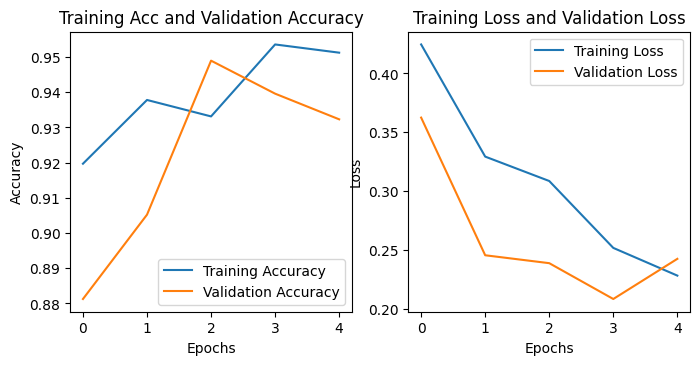

In [ ]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']



plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training Acc and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(2, 2, 2)
plt.plot( loss, label='Training Loss')
plt.plot( val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training Loss and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.xlimit()
plt.show()

# **4.Model Evaluation**


## 4.1 Testing the Test set

In [ ]:
test_loss, test_acc =model.evaluate(test,verbose=2)
print("\n Test Accuracy: ", test_acc)

17/17 - 16s - loss: 0.1748 - accuracy: 0.9263 - 16s/epoch - 959ms/step

 Test Accuracy:  0.9262759685516357


##4.1 Metrics Performance

In [ ]:
pre = Precision()
re = Recall()
acc =BinaryAccuracy()

In [ ]:
for batch in test.as_numpy_iterator():
  X, y= batch
  yhat = model.predict(X)
  yhat = np.argmax(yhat, axis=-1)
  y = np.argmax(y, axis=-1)
  pre.update_state(y,yhat)
  re.update_state(y,yhat)
  acc.update_state(y,yhat)


1/1 [==============================] - 0s 26ms/step


In [ ]:
f1_score = 2 * (pre.result().numpy() * re.result().numpy()) / (pre.result().numpy() + re.result().numpy())

In [ ]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}, f1_score:{f1_score}')

Precision:0.9935064911842346, Recall:0.9935064911842346, Accuracy:0.818525493144989, f1_score:0.9935064658468217


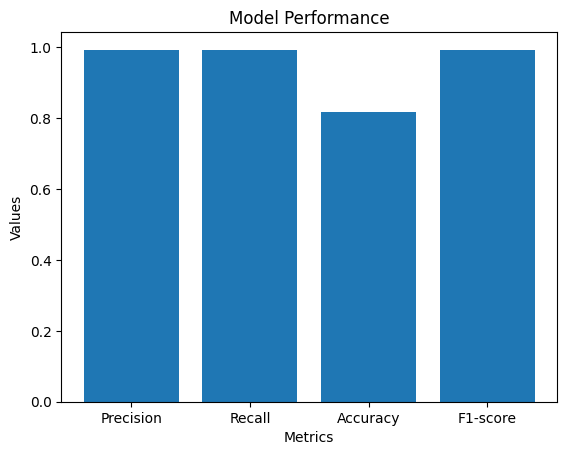

In [ ]:
# Define the metrics and their values
metrics = ['Precision', 'Recall', 'Accuracy', 'F1-score']
values = [pre.result().numpy(), re.result().numpy(), acc.result().numpy(), f1_score]

# Create a bar plot
plt.bar(metrics, values)

# Add labels and title
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Model Performance')

# Show the plot
plt.show()

#Confusion Matrix


####In a multiclass confusion matrix, the diagonal elements represent the number of correctly classified instances for each class, while the off-diagonal elements represent misclassifications

In [ ]:
from sklearn.metrics import confusion_matrix
conf_matrix = np.ones(shape=(3,3))
for batch in test.as_numpy_iterator():
  X, y= batch
  y_pred = model.predict(X)
  y_pred = np.argmax(y_pred, axis=1)
  y = np.argmax(y, axis=-1)
  cm = confusion_matrix(y, y_pred)
  conf_matrix += cm
  print(cm)


1/1 [==============================] - 0s 42ms/step
[[ 4  2  0]
 [ 0 17  1]
 [ 0  1  7]]
1/1 [==============================] - 0s 65ms/step
[[ 5  0  0]
 [ 0 23  1]
 [ 0  0  3]]
1/1 [==============================] - 0s 37ms/step
[[ 5  0  0]
 [ 1 21  1]
 [ 0  0  4]]
1/1 [==============================] - 0s 40ms/step
[[ 1  1  1]
 [ 0 25  0]
 [ 0  0  4]]
1/1 [==============================] - 0s 45ms/step
[[ 3  1  0]
 [ 0 26  1]
 [ 0  0  1]]
1/1 [==============================] - 0s 38ms/step
[[ 4  0  0]
 [ 0 23  4]
 [ 0  0  1]]
1/1 [==============================] - 0s 52ms/step
[[ 3  1  0]
 [ 0 17  3]
 [ 0  1  7]]
1/1 [==============================] - 0s 40ms/step
[[ 5  0  0]
 [ 0 18  2]
 [ 0  0  7]]
1/1 [==============================] - 0s 35ms/step
[[ 4  0  0]
 [ 0 19  2]
 [ 0  1  6]]
1/1 [==============================] - 0s 30ms/step
[[ 4  0  0]
 [ 0 20  1]
 [ 0  0  7]]
1/1 [==============================] - 0s 32ms/step
[[ 8  0  0]
 [ 0 18  1]
 [ 0  0  5]]
1/1 [================

In [ ]:
conf_matrix

array([[ 70.,   4.,   2.],
       [  6., 337.,  25.],
       [  2.,   9.,  83.]])

<Axes: >

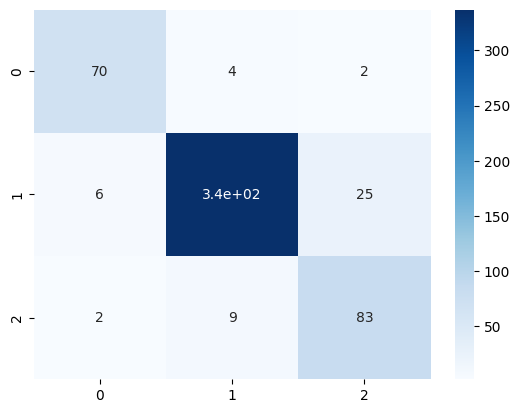

In [ ]:
sns.heatmap(conf_matrix, annot=True, cmap='Blues')

### 4.1 **Test Sample**

1/1 [==============================] - 8s 8s/step


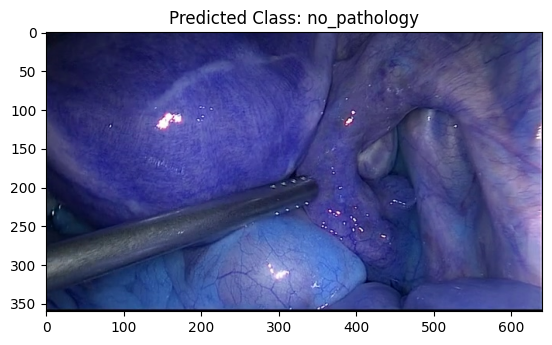

In [ ]:
img = cv2.imread('/content/drive/MyDrive/Data/no_pathology/f_1002.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
resize = tf.image.resize(img,(256,256))
image = np.expand_dims(resize,0)
pred = model.predict(image)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Predicted Class: {}'.format(class_names[np.argmax(pred)]))
plt.show()

In [ ]:
pred = model.predict(image)
class_index = np.argmax(pred)
class_name = class_names[class_index]
print('Predicted class name: ', class_name)


1/1 [==============================] - 0s 57ms/step
Predicted class name:  no_pathology


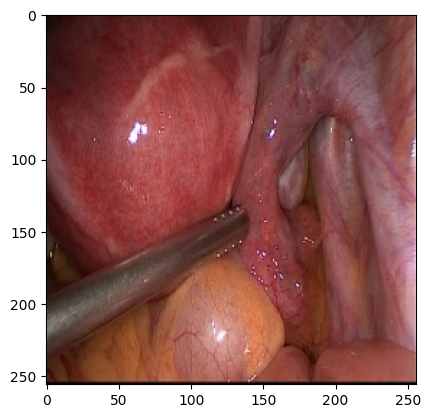

In [ ]:
resize = tf.image.resize(img,(256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

### Testing an image with the new model


In [ ]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/model/model2.h5')


In [ ]:
img = cv2.imread('/content/drive/MyDrive/Data/no_pathology/f_1107.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
resize = tf.image.resize(img,(256,256))
image = np.expand_dims(resize,0)
pred = new_model.predict(image)
label = np.argmax(pred)
# perc = pred[label]
pred[0][1]


1/1 [==============================] - 0s 85ms/step


0.99268204

## **The End**